<a href="https://colab.research.google.com/github/serverf21/Stock-Market-Prediction-and-Forecasting-LSTM-Neural-Networks/blob/main/Stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock market prediction and forecasting using Stacked LSTM (Long Short-term memory)**

Steps to perform

1. Collect the stock data
2. Preprocess the data (Train and Test)
3. Create a stacked LSTM model
4. Predict the test data and plot the output
5. Predict the future 30 days and plot the output

In [ ]:
##Keras and tensorflow > 2.0

In [1]:
import pandas_datareader as pdr
import os

In [2]:
key = '28cc5c87e6096b18a22217325fbb5004e713b2df'
df = pdr.get_data_tiingo('GOOG', api_key=key)

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [3]:
#Source the key from Tiingo website by using free account
df.to_csv('GOOG.csv')
import pandas as pd
df=pd.read_csv('GOOG.csv')

In [4]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2017-04-05 00:00:00+00:00,831.41,842.450,830.720,835.51,1555328,831.41,842.450,830.720,835.51,1555328,0.0,1.0
1,GOOG,2017-04-06 00:00:00+00:00,827.88,836.390,826.460,832.40,1254433,827.88,836.390,826.460,832.40,1254433,0.0,1.0
2,GOOG,2017-04-07 00:00:00+00:00,824.67,828.485,820.513,827.96,1056692,824.67,828.485,820.513,827.96,1056692,0.0,1.0
3,GOOG,2017-04-10 00:00:00+00:00,824.73,829.350,823.770,825.39,978905,824.73,829.350,823.770,825.39,978905,0.0,1.0
4,GOOG,2017-04-11 00:00:00+00:00,823.35,827.427,817.020,824.71,1079732,823.35,827.427,817.020,824.71,1079732,0.0,1.0


In [5]:
#head has data starting from April 2017
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,GOOG,2022-03-28 00:00:00+00:00,2839.00,2839.53,2796.5627,2813.69,1188654,2839.00,2839.53,2796.5627,2813.69,1188654,0.0,1.0
1254,GOOG,2022-03-29 00:00:00+00:00,2865.00,2883.25,2849.6800,2863.21,1433921,2865.00,2883.25,2849.6800,2863.21,1433921,0.0,1.0
1255,GOOG,2022-03-30 00:00:00+00:00,2852.89,2869.61,2843.3600,2857.40,1052319,2852.89,2869.61,2843.3600,2857.40,1052319,0.0,1.0
1256,GOOG,2022-03-31 00:00:00+00:00,2792.99,2852.89,2792.3800,2848.97,1475816,2792.99,2852.89,2792.3800,2848.97,1475816,0.0,1.0
1257,GOOG,2022-04-01 00:00:00+00:00,2814.00,2819.00,2775.9400,2800.20,1174001,2814.00,2819.00,2775.9400,2800.20,1174001,0.0,1.0


In [6]:
#tail has data ending up to 1 April 2022 (last Friday)
#Let's take only close column and train the model
#Thererafter, do the prediction of closing value only
df1=df.reset_index()['close']

In [7]:
df1.shape

(1258,)

In [8]:
df1

0        831.41
1        827.88
2        824.67
3        824.73
4        823.35
         ...   
1253    2839.00
1254    2865.00
1255    2852.89
1256    2792.99
1257    2814.00
Name: close, Length: 1258, dtype: float64

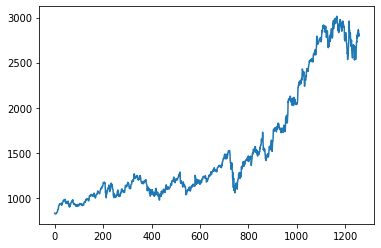

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
## LSTM are sensitive to the scale of the data 
## Therefore we apply MaxMin scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [11]:
#Let's scale all the values to the range 0 to 1
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
df1.shape

(1258, 1)

In [13]:
df1

array([[3.67897098e-03],
       [2.06770950e-03],
       [6.02511377e-04],
       ...,
       [9.26379500e-01],
       [8.99038264e-01],
       [9.08628237e-01]])

In [14]:
#df1 is now an array with all the values between 0 to 1
#Now split train and test data
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data, test_data=df1[0:training_size, :], df1[training_size:len(df1), :1]

In [15]:
training_size, test_size

(817, 441)

In [16]:
#training of data wouldn't be like a linear model.
#It will be by connecting a day's closing price by 3-4 features. 
# These 3-4 features would be the closing price of last 3-4 days.
# These number of previous records, which would go like a feature 
# are defined as time_step in our model


In [17]:
import numpy as np
#Convert the array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY=[], []
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step), 0]           ###i=0,1,2,3,....99
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)

In [18]:
### Reshape it into X = t, t+1, t+2, t+3 and Y = t+4
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(716, 100) (716,) (340, 100) (340,)


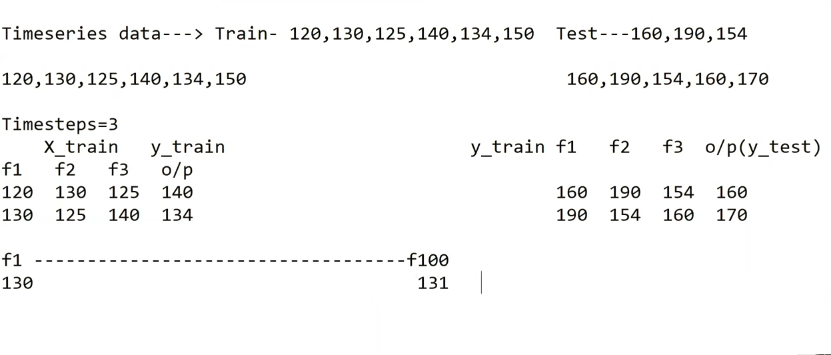

In [20]:
#reshape data to [samples, time_steps, features] which is required for LSTM
#Only 1 feature is there
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
#Create the stacked LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
#Learn about LSTM model and deploy it

In [24]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True,))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 17s 526ms/step - loss: 0.0099 - val_loss: 0.1471
Epoch 2/100
12/12 [==============================] - 4s 319ms/step - loss: 0.0020 - val_loss: 0.0773
Epoch 3/100
12/12 [==============================] - 4s 304ms/step - loss: 0.0015 - val_loss: 0.0838
Epoch 4/100
12/12 [==============================] - 3s 214ms/step - loss: 9.3860e-04 - val_loss: 0.0208
Epoch 5/100
12/12 [==============================] - 2s 191ms/step - loss: 7.1542e-04 - val_loss: 0.0031
Epoch 6/100
12/12 [==============================] - 2s 193ms/step - loss: 5.9849e-04 - val_loss: 0.0054
Epoch 7/100
12/12 [==============================] - 2s 194ms/step - loss: 5.2192e-04 - val_loss: 0.0017
Epoch 8/100
12/12 [==============================] - 2s 191ms/step - loss: 5.1545e-04 - val_loss: 0.0021
Epoch 9/100
12/12 [==============================] - 2s 187ms/step - loss: 4.8257e-04 - val_loss: 0.0028
Epoch 10/100
12/12 [==============================] - 2s 195ms/ste

In [27]:
import tensorflow as tf

In [28]:
tf.__version__

'2.8.0'

In [29]:
##Prediction and checking the performance matrix
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [30]:
##Transforming to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [31]:
##Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

1169.7766233472657

In [32]:
##Test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

1918.7259593586825

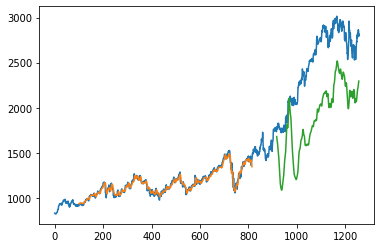

In [36]:
import numpy
#### Plotting
# Shift train predictions for plotting
look_back=100
trainPredictPlot=numpy.empty_like(df1)
trainPredictPlot[:, :]=np.nan ##initialize with null values
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot=numpy.empty_like(df1)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:(len(df1)-1), :] = test_predict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [37]:
len(test_data)

441

In [38]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [42]:
temp_input

[0.9866671535445468,
 0.9627264552703769,
 0.9638401884217396,
 0.9902913507666042,
 0.9879406435004086,
 0.9850924079002021,
 0.984964602456603,
 0.9999999999999998,
 0.9930939415655253,
 0.9668573097867019,
 0.9639223490640532,
 0.9635617551338989,
 0.9278538270883636,
 0.9580524276187563,
 0.9246221751573604,
 0.9170086223029628,
 0.9367134830178516,
 0.9252475089349697,
 0.9368960622229929,
 0.9756028537129764,
 0.9818470625288132,
 0.9762373164508427,
 0.9814316948371165,
 0.963443078650557,
 0.9476134615647949,
 0.9695047082612525,
 0.9464084388108616,
 0.9278264402075924,
 0.9241611626643784,
 0.9407667413719913,
 0.9656751094334111,
 0.9674415632431543,
 0.9758539001200459,
 0.9611015003446182,
 0.9616172865991428,
 0.9570345485500928,
 0.9449569341299873,
 0.9485628734315303,
 0.9425560175823773,
 0.8808168593638028,
 0.8798811409374527,
 0.8748921641569634,
 0.8892200672804371,
 0.9023977214115197,
 0.917282491110675,
 0.8943048981436259,
 0.9002889315921363,
 0.8683740865334

In [43]:
#demonstrating predictions for the next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.6749874]
101
1 day input [0.96272646 0.96384019 0.99029135 0.98794064 0.98509241 0.9849646
 1.         0.99309394 0.96685731 0.96392235 0.96356176 0.92785383
 0.95805243 0.92462218 0.91700862 0.93671348 0.92524751 0.93689606
 0.97560285 0.98184706 0.97623732 0.98143169 0.96344308 0.94761346
 0.96950471 0.94640844 0.92782644 0.92416116 0.94076674 0.96567511
 0.96744156 0.9758539  0.9611015  0.96161729 0.95703455 0.94495693
 0.94856287 0.94255602 0.88081686 0.87988114 0.87489216 0.88922007
 0.90239772 0.91728249 0.8943049  0.90028893 0.86837409 0.86254525
 0.84295906 0.81178823 0.81434434 0.78114687 0.80401035 0.80292401
 0.84097808 0.86296974 0.88287088 0.97560285 0.92643427 0.92977091
 0.89254301 0.89505347 0.91550234 0.88948024 0.84865097 0.85933185
 0.8696065  0.87930145 0.83202257 0.81521615 0.80549381 0.78890192
 0.83535464 0.8522067  0.85559811 0.84899787 0.85432462 0.85027592
 0.83032002 0.77867292 0.7861039  0.84624092 0.83543223 0.81528918
 0.78119708 0.80784908 0.84463879 0

In [44]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [45]:
import matplotlib.pyplot as plt
len(df1)

1258

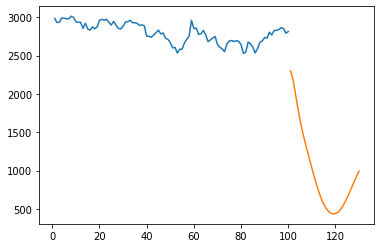

In [46]:
plt.plot(day_new, scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

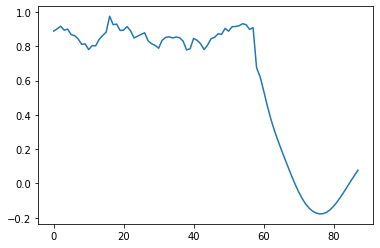

In [48]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [49]:
df3=scaler.inverse_transform(df3).tolist()

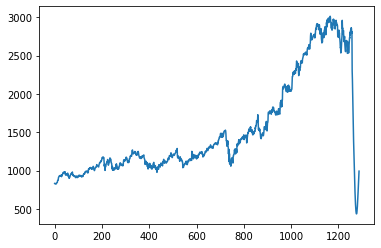

In [50]:
plt.plot(df3)